# jqdata实现《量化投资技术分析实战》中ama均线的计算

《量化投资技术分析实战》书中有对ama均线的介绍。并且通过公众号量化投资训练营，也找到了对ama均线的一些内容，综合形成这次ama均线的计算。

参考内容：

    濮元恺，《量化投资技术分析实战》
    量化投资训练营：
    1. 不可忽视的AMA自适应移动均线交易系统（1）
    2. 不可忽视的AMA自适应移动均线交易系统（2）
    3. 股票指数（含期货）择时交易方法分享（1）

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import  jqdatasdk

In [16]:
jqdatasdk.auth(tel, pwd)

In [17]:
zz500_df = jqdatasdk.get_price('000300.XSHG', start_date='2006-02-01', end_date='2018-11-19', frequency='daily', fields=['close']) 

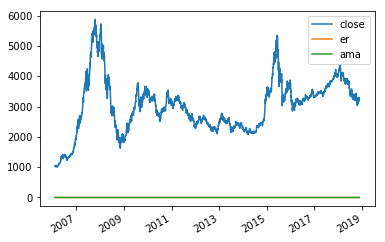

In [18]:
zz500_df['er'] = 0
zz500_df['ama'] = 0
zz500_df.plot()

# ama计算方法与关键参数
## ER效率系数

步骤1：价格方向

　　价格方向被表示为整个时间段中的净价格变化。比如，使用n天的间隔（或n小时）：

　　direction = price – price[n];

　　其中，direction是当前价格差或方向数值，price是当前价格（当日收盘价或小时收盘价），price[n]是n日前的收盘价（或n个周期前）。

步骤2：波动性

　　波动性是市场噪音的总数量，它可以用许多不同的方法定义，但是这个计算使用了所有“日到日”或“小时到小时”的价格变化的总和（每一个都作为一个正数），在同样的n个周期上。

　　如下表达：

　　volatility = @sum(@abs(price – price[1]), n);

　　其中，volatility是指波动性数值，@abs是绝对值函数，@sum(value, n)是n个周期中的数值之和函数。

步骤3：效率系数（ER）

　　以上两个成分被组合起来，以表达方向移动对噪音之比，称之为效率系数，ER：

　　Efficiency_Ratio = direction/volativity;
 ## 平滑系数
 　　fastest = 2/(N+1) = 2/(2+1) = 0.6667;

　　slowest = 2/(N+1) = 2/(30+1) = 0.0645;

　　smooth = ER*(fastest - slowest) + slowest;

　　c = smooth*smooth;
 ## AMA均线计算
    AMA = AMA[1] + c*(price – AMA[1]);

In [19]:
def cal_ama(last_ama, cp_df, var_er = 14, fastest_N = 2, slowest_N = 30):
    fastest = 2/(fastest_N+1)
    slowest = 2/(slowest_N+1)
    cp_df = cp_df[-var_er : ]
    direction = cp_df.iloc[-1] - cp_df.iloc[0]
#     print("direction           ==>" + str(direction))
    er_df = cp_df.diff()
    er_df = er_df.apply(lambda x : abs(x))
    volatility = er_df.sum()
#     print("volatility           ==>" + str(volatility))
    efficiency_ratio  = direction / volatility
#     print("efficiency_ratio==>" + str(efficiency_ratio))
    smooth = efficiency_ratio*(fastest - slowest) + slowest;
    c = smooth* smooth
#     print("c                       ==>" + str(c))
    last_ama = last_ama + c*(cp_df.iloc[-1] - last_ama)
    ama = last_ama
#     print("ama==>" + str(ama))
    
    return ama, efficiency_ratio

In [20]:
last_ama = 0
timeperiod = 14
pos = 0
for index, row in zz500_df.iterrows():
    if pos < timeperiod:
        last_ama = zz500_df[0:pos]['close'].mean()
#         print("last_ama==>" + str(last_ama))
        pos += 1
        continue
    
    cp_df = zz500_df[pos - timeperiod:pos]['close']
    
    ama, efficiency_ratio = cal_ama(last_ama, cp_df)

    zz500_df.loc[index,'er'] = efficiency_ratio
    zz500_df.loc[index,'ama'] = ama
    
    last_ama = ama
    
    pos += 1

# 显示ama

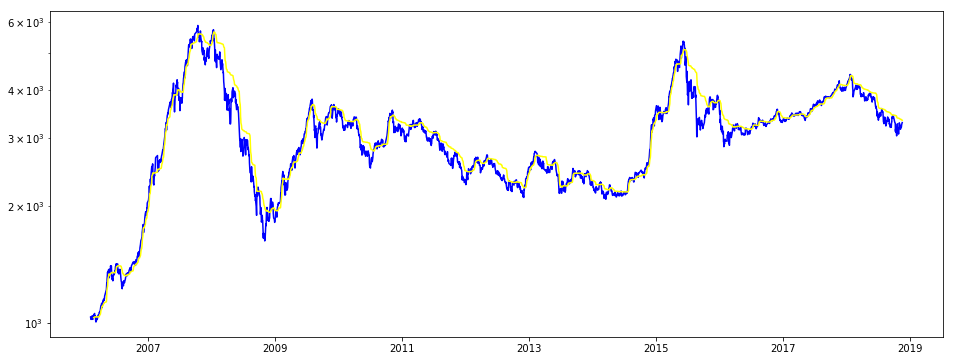

In [21]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,1,1)
ax1.semilogy(zz500_df.index, zz500_df['close'], color='blue', label='close')
ax1.semilogy(zz500_df.index, zz500_df['ama'], color='yellow', label='close')

# ax2 = ax1.twinx()
# ax2.plot(zz500_df.index, zz500_df['er'], color='red', label='close')

plt.show()

# 其他参数计算
## 1. 20日均线
## 2. ama均线标准差
在产生买入卖出信号时，有两种过滤条件，一种是是ama均线的波动率，另外一种是ama均线的差分波动率，都在此处进行计算

In [22]:
zz500_df['ma10'] = 0
zz500_df['ma20'] = 0
zz500_df['ama_diff_std20'] = 0
zz500_df['ama_std30'] = 0

ma10_pos = 10
ma20_pos = 20
ama_diff_std20_pos = 20
ama30_pos = 30
pos = 0
for index, row in zz500_df.iterrows():
    if pos < 10:
        pos += 1
        continue
        
    ma10 = zz500_df[pos-ma10_pos:pos]['close'].mean()
    zz500_df.loc[index,'ma10'] = ma10
    
    if pos < 20:
        pos += 1
        continue
        
    ma20 =  zz500_df[pos-ma20_pos:pos]['close'].mean()
    zz500_df.loc[index,'ma20'] = ma20
    
    if pos < 50:
        pos += 1
        continue
        
    ama_diff_std20 =  np.std(zz500_df[pos-ama_diff_std20_pos:pos]['ama'].diff(), ddof = 1)
    zz500_df.loc[index,'ama_diff_std20'] = ama_diff_std20
    
    ama_std30 =  np.std(zz500_df[pos-ama30_pos:pos]['ama'], ddof = 1)
    zz500_df.loc[index,'ama_std30'] = ama_std30
    
    pos += 1
#     break
    

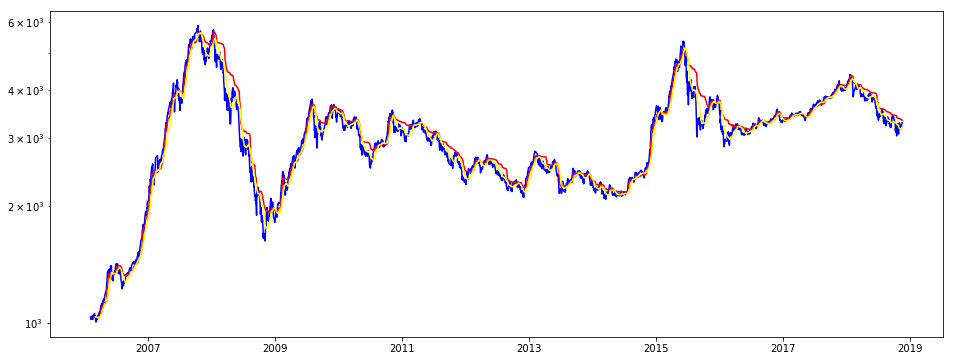

In [23]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,1,1)
ax1.semilogy(zz500_df.index, zz500_df['close'], color='blue', label='close')
ax1.semilogy(zz500_df.index, zz500_df['ama'], color='red', label='close')
ax1.semilogy(zz500_df.index, zz500_df['ma20'], color='yellow', label='close')

# ax2 = ax1.twinx()
# ax2.plot(zz500_df.index, zz500_df['er'], color='red', label='close')

plt.show()

In [24]:
# 保存到csv文件中，为后续回测，提供数据
zz500_df.to_csv('d:\\ama.csv')

# ama均线策略回测
在本地joinquant金融终端中读取存储的ama均线的数据，按照量化投资训练营中所给出的参数，进行回测，回测时直接读取的ama.csv中的每日ama和ama_std的数据，回测效果如下：

核心公式　
1. AMA均线 = 按照AMA公式计算价格，参数2-30，

2. ER效率系数参数14

3. 过滤器 = AMA均线的30日标准差 * 过滤器系数（0.1）

核心规则：

1. 两日AMA差值大于过滤器，做多

2. 两日AMA差值小于过滤器，平多
![title](ama_bt.PNG)

# 与量化投资训练营中的回测进行对比
使用同样的参数进行构造，与量化投资训练营的回测数据还是有些许差异
![title](ama_lhtzxly.jpeg)